In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from gtfparse import read_gtf
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import matplotlib.lines as mlines
from scipy.stats import ttest_ind, mannwhitneyu, spearmanr, pearsonr
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import fdrcorrection
import bioframe
import warnings
warnings.filterwarnings('ignore')

### Differential peaks

In [3]:
# Read H3K27ac peaks
h3k27ac_peaks = pd.read_csv('/DATA/users/magnitov/tacl/chipseq/peaks/all_H3K27ac_peaks.canonical.replicated.no_blacklist.merged.bed',
                   sep = '\t', header = None)
h3k27ac_peaks.columns = ['chrom', 'start', 'end']
h3k27ac_peaks['peak_id'] = ['_'.join([x[0], str(x[1]), str(x[2])]) for x in h3k27ac_peaks.values]

# Read H3K4me3 peaks
h3k4me3_peaks = pd.read_csv('/DATA/users/magnitov/tacl/chipseq/peaks/all_H3K4me3_peaks.canonical.replicated.no_blacklist.merged.bed',
                   sep = '\t', header = None)
h3k4me3_peaks.columns = ['chrom', 'start', 'end']

# Read TACL domains peaks
tacl_domains = pd.read_csv('/DATA/users/magnitov/tacl/4c/TACL_domains_HMM.bed',sep = '\t', header = None)
tacl_domains.columns = ['chrom', 'start', 'end', 'teto_id']

h3k27ac_promoter_peaks = bioframe.overlap(h3k27ac_peaks, h3k4me3_peaks, how='left').dropna()['peak_id'].values
h3k27ac_peaks['peak_type'] = ['promoter' if x in h3k27ac_promoter_peaks else 'enhancer' for x in h3k27ac_peaks['peak_id'].values]
h3k27ac_tacl_domains_peaks = bioframe.overlap(h3k27ac_peaks, tacl_domains, how='left').dropna()['peak_id'].values
h3k27ac_peaks['tacl_domain'] = [1 if x in h3k27ac_tacl_domains_peaks else 0 for x in h3k27ac_peaks['peak_id'].values]
h3k27ac_peaks.head()

,chrom,start,end,peak_id,peak_type,tacl_domain
0,chr1,826717,827502,chr1_826717_827502,promoter,0
1,chr1,903704,905743,chr1_903704_905743,promoter,0
2,chr1,924680,925326,chr1_924680_925326,promoter,0
3,chr1,939722,940110,chr1_939722_940110,enhancer,0
4,chr1,958613,959167,chr1_958613_959167,promoter,0


In [3]:
h3k27ac_peaks[(h3k27ac_peaks['tacl_domain'] == 1) & (h3k27ac_peaks['peak_type'] == 'enhancer')].to_csv('/DATA/users/magnitov/tacl/chipseq/peaks/H3K27ac_peaks.tacl_domains.enhancer.bed', sep = '\t', header = 0, index = 0)
h3k27ac_peaks[(h3k27ac_peaks['tacl_domain'] == 1) & (h3k27ac_peaks['peak_type'] == 'promoter')].to_csv('/DATA/users/magnitov/tacl/chipseq/peaks/H3K27ac_peaks.tacl_domains.promoter.bed', sep = '\t', header = 0, index = 0)
h3k27ac_peaks[(h3k27ac_peaks['tacl_domain'] == 0) & (h3k27ac_peaks['peak_type'] == 'enhancer')].to_csv('/DATA/users/magnitov/tacl/chipseq/peaks/H3K27ac_peaks.other.enhancer.bed', sep = '\t', header = 0, index = 0)
h3k27ac_peaks[(h3k27ac_peaks['tacl_domain'] == 0) & (h3k27ac_peaks['peak_type'] == 'promoter')].to_csv('/DATA/users/magnitov/tacl/chipseq/peaks/H3K27ac_peaks.other.promoter.bed', sep = '\t', header = 0, index = 0)

#### T-MAU2 vs T-mCherry

In [5]:
dars_tmau2_tmcherry = pd.read_csv('/DATA/users/magnitov/tacl/chipseq/dars/dars_H3K27ac_TMAU2_vs_TmCherry_DESeq2.csv', sep = '\s+', header = 0)
dars_tmau2_tmcherry['peak_id'] = dars_tmau2_tmcherry.index
dars_tmau2_tmcherry.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,peak_id
chr1_826717_827502,34.270023,-0.204440,0.544186,-0.375681,0.707154,0.938177,chr1_826717_827502
chr1_903704_905743,345.991114,-0.111668,0.170297,-0.655726,0.512000,0.878668,chr1_903704_905743
chr1_924680_925326,41.099939,-0.418224,0.476324,-0.878024,0.379931,0.820299,chr1_924680_925326
chr1_939722_940110,25.159067,-0.187711,0.619659,-0.302925,0.761947,NaN,chr1_939722_940110
chr1_958613_959167,65.530219,0.179381,0.367832,0.487672,0.625782,0.917264,chr1_958613_959167


In [6]:
dars_tmau2_tmcherry = dars_tmau2_tmcherry.merge(h3k27ac_peaks, on = 'peak_id')

columns_to_save = ['chrom', 'start', 'end', 'peak_id', 'peak_type', 'tacl_domain', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
dars_tmau2_tmcherry = dars_tmau2_tmcherry[columns_to_save]

dars_tmau2_tmcherry.sort_values('padj').head()

,chrom,start,end,peak_id,peak_type,tacl_domain,log2FoldChange,baseMean,pvalue,padj
4175,chr1,237832189,237833132,chr1_237832189_237833132,enhancer,1,-1.792639,336.715720,1.151798e-21,2.458916e-17
41994,chr7,34303792,34305167,chr7_34303792_34305167,promoter,0,1.464875,498.258190,5.916385e-22,2.458916e-17
4176,chr1,237833932,237835191,chr1_237833932_237835191,enhancer,1,-1.235331,512.894238,3.684216e-17,5.243499e-13
46464,chr9,34071182,34072171,chr9_34071182_34072171,enhancer,1,3.570401,80.017767,1.187681e-15,1.267760e-11
2394,chr1,145764059,145765205,chr1_145764059_145765205,enhancer,0,1.590502,299.761133,9.153341e-15,7.816404e-11


In [12]:
dars_tmau2_tmcherry.fillna(1).sort_values('padj').to_csv('/DATA/users/magnitov/tacl/H3K27ac_TACL-ON_vs_Cherry_deseq2.tsv', 
                           sep = '\t', header = 1, index = 0)

In [6]:
dars_tmau2_tmcherry_up = dars_tmau2_tmcherry[(dars_tmau2_tmcherry['padj'] < 0.05) & (dars_tmau2_tmcherry['log2FoldChange'] > 0.5)]
dars_tmau2_tmcherry_down = dars_tmau2_tmcherry[(dars_tmau2_tmcherry['padj'] < 0.05) & (dars_tmau2_tmcherry['log2FoldChange'] < -0.5)]
dars_tmau2_tmcherry_stable = dars_tmau2_tmcherry[~dars_tmau2_tmcherry['peak_id'].isin([x for x in dars_tmau2_tmcherry['peak_id'].values \
                                          if x in dars_tmau2_tmcherry_down['peak_id'].values or x in dars_tmau2_tmcherry_up['peak_id'].values])]

print('Up-regulated:', len(dars_tmau2_tmcherry_up))
print('Down-regulated:', len(dars_tmau2_tmcherry_down))
print('No change:', len(dars_tmau2_tmcherry_stable))

Up-regulated: 788
Down-regulated: 259
No change: 49488


#### T-MAU2+Dox vs T-MAU2

In [8]:
dars_dox_tmau2 = pd.read_csv('/DATA/users/magnitov/tacl/chipseq/dars/dars_H3K27ac_TMAU2_Dox_vs_TMAU2_DESeq2.csv', sep = '\s+', header = 0)
dars_dox_tmau2['peak_id'] = dars_dox_tmau2.index
dars_dox_tmau2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,peak_id
chr1_826717_827502,34.270023,-0.163154,0.551672,-0.295745,0.767425,0.999989,chr1_826717_827502
chr1_903704_905743,345.991114,-0.257452,0.172752,-1.490299,0.136146,0.999989,chr1_903704_905743
chr1_924680_925326,41.099939,-0.081849,0.485608,-0.168549,0.866151,0.999989,chr1_924680_925326
chr1_939722_940110,25.159067,0.525829,0.613616,0.856935,0.391481,0.999989,chr1_939722_940110
chr1_958613_959167,65.530219,-0.236468,0.369465,-0.640029,0.522154,0.999989,chr1_958613_959167


In [9]:
dars_dox_tmau2 = dars_dox_tmau2.merge(h3k27ac_peaks, on = 'peak_id')

columns_to_save = ['chrom', 'start', 'end', 'peak_id', 'peak_type', 'tacl_domain', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
dars_dox_tmau2 = dars_dox_tmau2[columns_to_save]

dars_dox_tmau2.sort_values('padj').head()

,chrom,start,end,peak_id,peak_type,tacl_domain,log2FoldChange,baseMean,pvalue,padj
0,chr1,826717,827502,chr1_826717_827502,promoter,0,-0.163154,34.270023,0.767425,0.999989
33684,chr4,90141642,90142089,chr4_90141642_90142089,enhancer,0,0.554204,38.408777,0.273269,0.999989
33685,chr4,90171674,90172820,chr4_90171674_90172820,enhancer,0,-0.057965,82.878959,0.861665,0.999989
33686,chr4,90536238,90536666,chr4_90536238_90536666,enhancer,0,-0.051500,18.401273,0.939836,0.999989
33687,chr4,90732921,90733203,chr4_90732921_90733203,enhancer,0,0.779673,12.137042,0.364677,0.999989


In [11]:
dars_dox_tmau2.fillna(1).sort_values('padj').to_csv('/DATA/users/magnitov/tacl/H3K27ac_TACL-OFF_vs_TACL-ON_deseq2.tsv', 
                           sep = '\t', header = 1, index = 0)

In [9]:
dars_dox_tmau2_up = dars_dox_tmau2[(dars_dox_tmau2['padj'] < 0.05) & (dars_dox_tmau2['log2FoldChange'] > 0.5)]
dars_dox_tmau2_down = dars_dox_tmau2[(dars_dox_tmau2['padj'] < 0.05) & (dars_dox_tmau2['log2FoldChange'] < -0.5)]
dars_dox_tmau2_stable = dars_dox_tmau2[~dars_dox_tmau2['peak_id'].isin([x for x in dars_dox_tmau2['peak_id'].values \
                                          if x in dars_dox_tmau2_down['peak_id'].values or x in dars_dox_tmau2_up['peak_id'].values])]

print('Up-regulated:', len(dars_dox_tmau2_up))
print('Down-regulated:', len(dars_dox_tmau2_down))
print('No change:', len(dars_dox_tmau2_stable))

Up-regulated: 0
Down-regulated: 0
No change: 50535


### Volcano plots

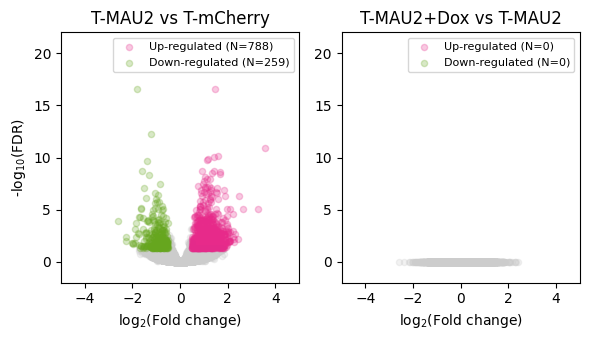

In [18]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(dars_tmau2_tmcherry_stable['log2FoldChange'], -np.log10(dars_tmau2_tmcherry_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_tmau2_tmcherry_up['log2FoldChange'], -np.log10(dars_tmau2_tmcherry_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated (N=' + str(len(dars_tmau2_tmcherry_up)) + ')', alpha = 0.25, s = 20)
plt.scatter(dars_tmau2_tmcherry_down['log2FoldChange'], -np.log10(dars_tmau2_tmcherry_down['padj']), 
            color = '#66A61E', label = 'Down-regulated (N=' + str(len(dars_tmau2_tmcherry_down)) + ')', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.ylabel(r'-log$_{10}$(FDR)', fontsize = 10)
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(dars_dox_tmau2_stable['log2FoldChange'], -np.log10(dars_dox_tmau2_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_dox_tmau2_up['log2FoldChange'], -np.log10(dars_dox_tmau2_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated (N=' + str(len(dars_dox_tmau2_up)) + ')', alpha = 0.25, s = 20)
plt.scatter(dars_dox_tmau2_down['log2FoldChange'], -np.log10(dars_dox_tmau2_down['padj']), 
            color = '#66A61E', label = 'Down-regulated (N=' + str(len(dars_dox_tmau2_down)) + ')', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/h3k27ac_volcano.pdf', bbox_inches = 'tight')
plt.show()

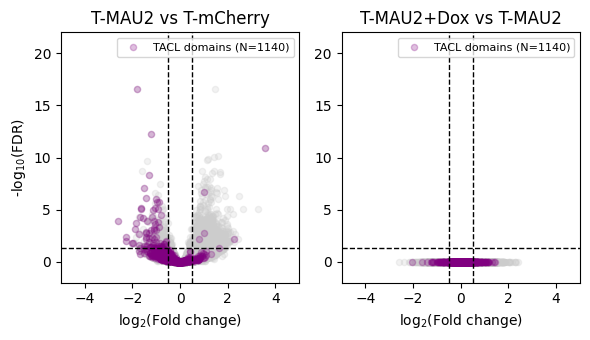

In [176]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(dars_tmau2_tmcherry['log2FoldChange'], 
            -np.log10(dars_tmau2_tmcherry['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['log2FoldChange'], 
            -np.log10(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['padj']), 
            color = 'purple', label = 'TACL domains (N=' + str(len(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1])) + ')', alpha = 0.25, s = 20)
plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.ylabel(r'-log$_{10}$(FDR)', fontsize = 10)
plt.axvline(0.5, lw = 1, ls = '--', color = 'k')
plt.axvline(-0.5, lw = 1, ls = '--', color = 'k')
plt.axhline(-np.log10(0.05), lw = 1, ls = '--', color = 'k')
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(dars_dox_tmau2['log2FoldChange'], 
            -np.log10(dars_dox_tmau2['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['log2FoldChange'], 
            -np.log10(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['padj']), 
            color = 'purple', label = 'TACL domains (N=' + str(len(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1])) + ')', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.axvline(0.5, lw = 1, ls = '--', color = 'k')
plt.axvline(-0.5, lw = 1, ls = '--', color = 'k')
plt.axhline(-np.log10(0.05), lw = 1, ls = '--', color = 'k')
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/h3k27ac_volcano_peaks_color_by_hmm.pdf', bbox_inches = 'tight')
plt.show()

In [168]:
dars_tmau2_tmcherry

,chrom,start,end,peak_id,peak_type,tacl_domain,log2FoldChange,baseMean,pvalue,padj
0,chr1,826717,827502,chr1_826717_827502,promoter,0,-0.204440,34.270023,0.707154,0.938177
1,chr1,903704,905743,chr1_903704_905743,promoter,0,-0.111668,345.991114,0.512000,0.878668
2,chr1,924680,925326,chr1_924680_925326,promoter,0,-0.418224,41.099939,0.379931,0.820299
3,chr1,939722,940110,chr1_939722_940110,enhancer,0,-0.187711,25.159067,0.761947,NaN
4,chr1,958613,959167,chr1_958613_959167,promoter,0,0.179381,65.530219,0.625782,0.917264
...,...,...,...,...,...,...,...,...,...,...
50530,chrX,155287058,155287664,chrX_155287058_155287664,enhancer,0,0.341286,73.870501,0.343960,0.799276
50531,chrX,155310449,155311839,chrX_155310449_155311839,enhancer,0,0.274804,158.748557,0.257662,0.737386
50532,chrX,155533457,155534624,chrX_155533457_155534624,enhancer,0,0.786338,45.672168,0.085791,0.508226
50533,chrX,155592662,155593486,chrX_155592662_155593486,enhancer,0,0.321394,240.159946,0.108943,0.556075


### MA plots

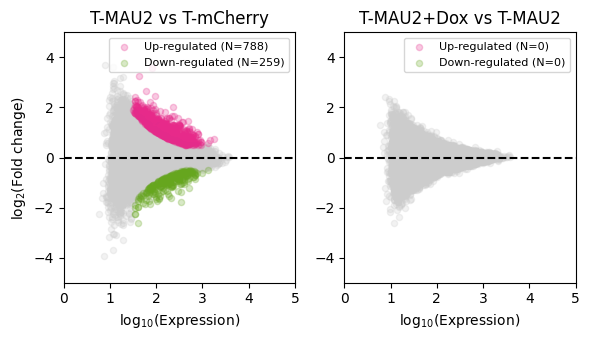

In [22]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(np.log10(dars_tmau2_tmcherry_stable['baseMean']), dars_tmau2_tmcherry_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_tmau2_tmcherry_up['baseMean']), dars_tmau2_tmcherry_up['log2FoldChange'], 
            color = 'purple', label = 'Up-regulated (N=' + str(len(dars_tmau2_tmcherry_up)) + ')', alpha = 0.25, s = 20)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylabel('log$_2$(Fold change)', fontsize = 10)
plt.ylim((-5, 5))
plt.xlim((0, 5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(np.log10(dars_dox_tmau2_stable['baseMean']), dars_dox_tmau2_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_dox_tmau2_up['baseMean']), dars_dox_tmau2_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated (N=' + str(len(dars_dox_tmau2_up)) + ')', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_dox_tmau2_down['baseMean']), dars_dox_tmau2_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated (N=' + str(len(dars_dox_tmau2_down)) + ')', alpha = 0.25, s = 20)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-5, 5))
plt.xlim((0, 5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/h3k27ac_ma.pdf', bbox_inches = 'tight')
plt.show()

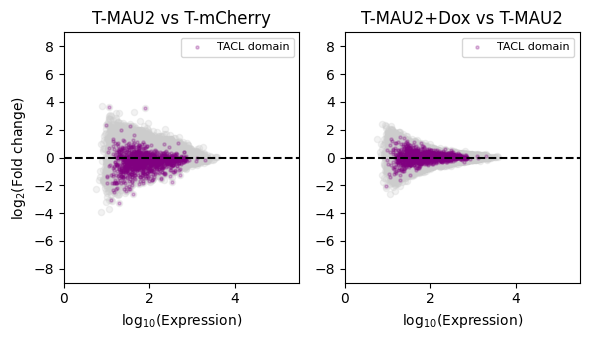

In [23]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(np.log10(dars_tmau2_tmcherry['baseMean']), dars_tmau2_tmcherry['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['baseMean']), 
            dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['log2FoldChange'], 
            color = 'purple', label = 'TACL domain', alpha = 0.25, s = 5)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylabel('log$_2$(Fold change)', fontsize = 10)
plt.ylim((-9, 9))
plt.xlim((0, 5.5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(np.log10(dars_dox_tmau2['baseMean']), dars_dox_tmau2['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['baseMean']), 
            dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['log2FoldChange'], 
            color = 'purple', label = 'TACL domain', alpha = 0.25, s = 5)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-9, 9))
plt.xlim((0, 5.5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

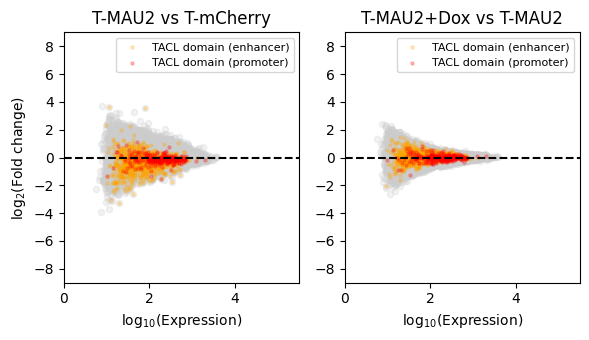

In [24]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(np.log10(dars_tmau2_tmcherry['baseMean']), dars_tmau2_tmcherry['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')]['baseMean']), 
            dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')]['log2FoldChange'], 
            color = 'orange', label = 'TACL domain (enhancer)', alpha = 0.25, s = 5)
plt.scatter(np.log10(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')]['baseMean']), 
            dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')]['log2FoldChange'], 
            color = 'red', label = 'TACL domain (promoter)', alpha = 0.25, s = 5)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylabel('log$_2$(Fold change)', fontsize = 10)
plt.ylim((-9, 9))
plt.xlim((0, 5.5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(np.log10(dars_dox_tmau2['baseMean']), dars_dox_tmau2['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'enhancer')]['baseMean']), 
            dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'enhancer')]['log2FoldChange'], 
            color = 'orange', label = 'TACL domain (enhancer)', alpha = 0.25, s = 5)
plt.scatter(np.log10(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'promoter')]['baseMean']), 
            dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'promoter')]['log2FoldChange'], 
            color = 'red', label = 'TACL domain (promoter)', alpha = 0.25, s = 5)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-9, 9))
plt.xlim((0, 5.5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

### Counts inside/outside TACL domains

In [25]:
pd.DataFrame([[len(dars_tmau2_tmcherry_down[dars_tmau2_tmcherry_down['tacl_domain'] == 1]),
               len(dars_tmau2_tmcherry_up[dars_tmau2_tmcherry_up['tacl_domain'] == 1]),
               len(dars_tmau2_tmcherry_stable[dars_tmau2_tmcherry_stable['tacl_domain'] == 1])],
              [len(dars_tmau2_tmcherry_down[dars_tmau2_tmcherry_down['tacl_domain'] == 0]),
               len(dars_tmau2_tmcherry_up[dars_tmau2_tmcherry_up['tacl_domain'] == 0]),
               len(dars_tmau2_tmcherry_stable[dars_tmau2_tmcherry_stable['tacl_domain'] == 0])]],
             columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['TACL domain', 'Other']).transpose()

,TACL domain,Other
Down-regulated,74,185
Up-regulated,6,782
Stable,1060,48428


In [26]:
pd.DataFrame([[len(dars_tmau2_tmcherry_down[(dars_tmau2_tmcherry_down['tacl_domain'] == 1) & (dars_tmau2_tmcherry_down['peak_type'] == 'enhancer')]),
               len(dars_tmau2_tmcherry_up[(dars_tmau2_tmcherry_up['tacl_domain'] == 1) & (dars_tmau2_tmcherry_up['peak_type'] == 'enhancer')]),
               len(dars_tmau2_tmcherry_stable[(dars_tmau2_tmcherry_stable['tacl_domain'] == 1) & (dars_tmau2_tmcherry_stable['peak_type'] == 'enhancer')])],
              [len(dars_tmau2_tmcherry_down[(dars_tmau2_tmcherry_down['tacl_domain'] == 0) & (dars_tmau2_tmcherry_down['peak_type'] == 'enhancer')]),
               len(dars_tmau2_tmcherry_up[(dars_tmau2_tmcherry_up['tacl_domain'] == 0) & (dars_tmau2_tmcherry_up['peak_type'] == 'enhancer')]),
               len(dars_tmau2_tmcherry_stable[(dars_tmau2_tmcherry_stable['tacl_domain'] == 0) & (dars_tmau2_tmcherry_stable['peak_type'] == 'enhancer')])]],
             columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['TACL domain', 'Other']).transpose()

,TACL domain,Other
Down-regulated,70,147
Up-regulated,5,713
Stable,802,33091


In [27]:
pd.DataFrame([[len(dars_tmau2_tmcherry_down[(dars_tmau2_tmcherry_down['tacl_domain'] == 1) & (dars_tmau2_tmcherry_down['peak_type'] == 'promoter')]),
               len(dars_tmau2_tmcherry_up[(dars_tmau2_tmcherry_up['tacl_domain'] == 1) & (dars_tmau2_tmcherry_up['peak_type'] == 'promoter')]),
               len(dars_tmau2_tmcherry_stable[(dars_tmau2_tmcherry_stable['tacl_domain'] == 1) & (dars_tmau2_tmcherry_stable['peak_type'] == 'promoter')])],
              [len(dars_tmau2_tmcherry_down[(dars_tmau2_tmcherry_down['tacl_domain'] == 0) & (dars_tmau2_tmcherry_down['peak_type'] == 'promoter')]),
               len(dars_tmau2_tmcherry_up[(dars_tmau2_tmcherry_up['tacl_domain'] == 0) & (dars_tmau2_tmcherry_up['peak_type'] == 'promoter')]),
               len(dars_tmau2_tmcherry_stable[(dars_tmau2_tmcherry_stable['tacl_domain'] == 0) & (dars_tmau2_tmcherry_stable['peak_type'] == 'promoter')])]],
             columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['TACL domain', 'Other']).transpose()

,TACL domain,Other
Down-regulated,4,38
Up-regulated,1,69
Stable,258,15337


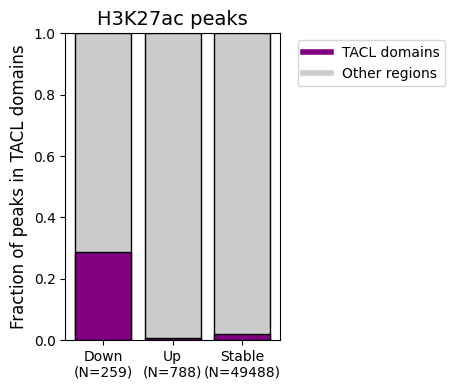

In [28]:
plt.figure(figsize = (3, 4))
plt.title('H3K27ac peaks', fontsize = 14)
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [len(dars_tmau2_tmcherry_down[dars_tmau2_tmcherry_down['tacl_domain'] == 1])/len(dars_tmau2_tmcherry_down),
                    len(dars_tmau2_tmcherry_up[dars_tmau2_tmcherry_up['tacl_domain'] == 1])/len(dars_tmau2_tmcherry_up),
                    len(dars_tmau2_tmcherry_stable[dars_tmau2_tmcherry_stable['tacl_domain'] == 1])/len(dars_tmau2_tmcherry_stable)],
        edgecolor = 'k', lw = 1, color = 'purple')
plt.xticks([0, 1, 2], ['Down\n(N=' + str(len(dars_tmau2_tmcherry_down)) + ')', 
                       'Up\n(N=' + str(len(dars_tmau2_tmcherry_up)) + ')', 
                       'Stable\n(N=' + str(len(dars_tmau2_tmcherry_stable)) + ')'])
plt.ylabel('Fraction of peaks in TACL domains', fontsize = 12)
plt.ylim((0, 1))
plt.tight_layout()
custom_lines = [Line2D([0], [0], color='purple', lw=4),
                Line2D([0], [0], color='#CCCCCC', lw=4)]
plt.legend(custom_lines, ['TACL domains', 'Other regions'], bbox_to_anchor = (1.05, 1))
plt.savefig('/DATA/users/magnitov/tacl/figures/h3k27ac_peaks_overlap_tacl_domains.pdf', bbox_inches = 'tight')
plt.show()

### Violin plots signal difference

H3K27ac enhancer peaks inside vs outside TACL domain: U-test p-value = 3.353357650537205e-106
H3K27ac promoter peaks inside vs outside TACL domain: U-test p-value = 0.5124766123083859


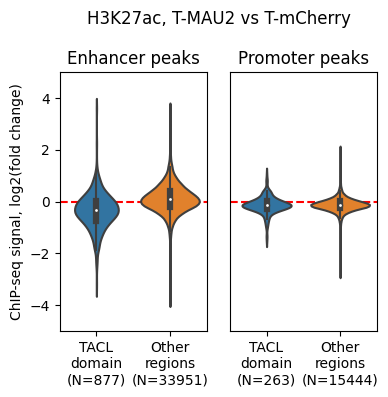

In [165]:
mwu_test_tacl = mannwhitneyu(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')]['log2FoldChange'].values,
                             dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 0) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')]['log2FoldChange'].values)
print('H3K27ac enhancer peaks inside vs outside TACL domain: U-test p-value =', mwu_test_tacl[1])
mwu_test_tacl = mannwhitneyu(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')]['log2FoldChange'].values,
                             dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 0) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')]['log2FoldChange'].values)
print('H3K27ac promoter peaks inside vs outside TACL domain: U-test p-value =', mwu_test_tacl[1])

plt.figure(figsize = (4, 4))
plt.suptitle('H3K27ac, T-MAU2 vs T-mCherry', x = 0.56)

plt.subplot(121)
plt.title('Enhancer peaks', fontsize = 12)
sns.violinplot(data = [dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')]['log2FoldChange'].values,
                       dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 0) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')]['log2FoldChange'].values],
               density_norm = 'width')
plt.axhline(0, zorder = -3, color = 'r', ls = '--')
plt.xticks([0, 1], ['TACL\ndomain\n(N=' + str(len(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')])) + ')', 
                    'Other\nregions\n(N=' + str(len(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 0) & (dars_tmau2_tmcherry['peak_type'] == 'enhancer')])) + ')'])
plt.ylabel('ChIP-seq signal, log2(fold change)')
plt.ylim((-5, 5))

plt.subplot(122)
plt.title('Promoter peaks')
sns.violinplot(data = [dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')]['log2FoldChange'].values,
                       dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 0) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')]['log2FoldChange'].values])
plt.axhline(0, zorder = -3, color = 'r', ls = '--')
plt.xticks([0, 1], ['TACL\ndomain\n(N=' + str(len(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 1) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')])) + ')', 
                    'Other\nregions\n(N=' + str(len(dars_tmau2_tmcherry[(dars_tmau2_tmcherry['tacl_domain'] == 0) & (dars_tmau2_tmcherry['peak_type'] == 'promoter')])) + ')'])
plt.yticks([], [])
plt.ylim((-5, 5))

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/h3k27ac_violinplots.pdf', bbox_inches = 'tight')
plt.show()

H3K27ac enhancer peaks inside vs outside TACL domain: U-test p-value = 4.433931925949542e-09
H3K27ac promoter peaks inside vs outside TACL domain: U-test p-value = 0.4889366811010568


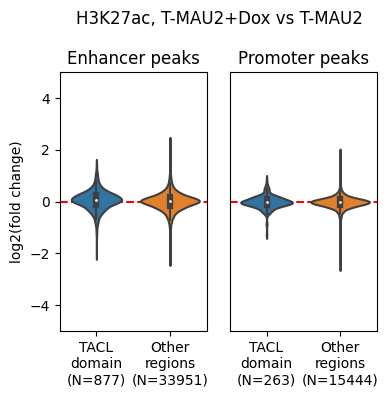

In [166]:
mwu_test_tacl = mannwhitneyu(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'enhancer')]['log2FoldChange'].values,
                             dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 0) & (dars_dox_tmau2['peak_type'] == 'enhancer')]['log2FoldChange'].values)
print('H3K27ac enhancer peaks inside vs outside TACL domain: U-test p-value =', mwu_test_tacl[1])
mwu_test_tacl = mannwhitneyu(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'promoter')]['log2FoldChange'].values,
                             dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 0) & (dars_dox_tmau2['peak_type'] == 'promoter')]['log2FoldChange'].values)
print('H3K27ac promoter peaks inside vs outside TACL domain: U-test p-value =', mwu_test_tacl[1])

plt.figure(figsize = (4, 4))
plt.suptitle('H3K27ac, T-MAU2+Dox vs T-MAU2', x = 0.56)

plt.subplot(121)
plt.title('Enhancer peaks')
sns.violinplot(data = [dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'enhancer')]['log2FoldChange'].values,
                       dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 0) & (dars_dox_tmau2['peak_type'] == 'enhancer')]['log2FoldChange'].values])
plt.axhline(0, zorder = -3, color = 'r', ls = '--')
plt.xticks([0, 1], ['TACL\ndomain\n(N=' + str(len(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'enhancer')])) + ')', 
                    'Other\nregions\n(N=' + str(len(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 0) & (dars_dox_tmau2['peak_type'] == 'enhancer')])) + ')'])
plt.ylabel('log2(fold change)')
plt.ylim((-5, 5))

plt.subplot(122)
plt.title('Promoter peaks')
sns.violinplot(data = [dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'promoter')]['log2FoldChange'].values,
                       dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 0) & (dars_dox_tmau2['peak_type'] == 'promoter')]['log2FoldChange'].values])
plt.axhline(0, zorder = -3, color = 'r', ls = '--')
plt.xticks([0, 1], ['TACL\ndomain\n(N=' + str(len(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 1) & (dars_dox_tmau2['peak_type'] == 'promoter')])) + ')', 
                    'Other\nregions\n(N=' + str(len(dars_dox_tmau2[(dars_dox_tmau2['tacl_domain'] == 0) & (dars_dox_tmau2['peak_type'] == 'promoter')])) + ')'])
plt.yticks([], [])
plt.ylim((-5, 5))

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/h3k27ac_dox_violinplots.pdf', bbox_inches = 'tight')
plt.show()